In [10]:
import src.get_data as get_data
import src.load_data as load
import src.compute_income as ci
import src.make_plots as MP
import src.indicators as ind


import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

%matplotlib inline

%load_ext autoreload
%autoreload 2


sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import datetime 
from pandas_datareader import data
import datetime as dt
import time 

from keras.callbacks import History 
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model, save_model
from keras import backend as K

import time
from sklearn import metrics

WINDOW = 22

In [60]:
def build_model(input_shape):
    
    # LSTM NN
    d = 0.2
    model = Sequential()
    
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="normal",activation='relu'))        
    model.add(Dense(1,kernel_initializer="normal",activation='linear'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    
    return model


def nextDayPrediction(typeBlockchain, stock):    
    """
    Triggers for plotting
    """
    plot = True
    plotHictory = True
    interactiveGrapth = True
    plotForTrain = False
    
    loaded = get_data.get_data_frame(typeBlockchain, stock)
    loaded.index = loaded.date

    loaded = ind.volatility(loaded)
    loaded = loaded.dropna()
    
    x = loaded[['volatility']].copy()
    
    print (x.head())
    y = loaded[['close']].copy()

    NUM_FEATURES = x.shape[1]

    scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    x[['volatility']] = scaler.fit_transform(x)
    y['close'] = y_scaler.fit_transform(y.values.reshape(-1,1))
    x[['cl_2']] = y

    X_train, y_train, X_test, y_test = load.load_data(x, WINDOW, train_size= 0.96,\
                                                      TrainTest = True)
    x = x[['volatility']] 

    model = build_model(input_shape=(WINDOW, NUM_FEATURES))


    print('START FIT MODEL...')
    history = History()
    history= model.fit(X_train, y_train, validation_data=(X_test, y_test),  batch_size=32,\
                       epochs=2,verbose=0,    callbacks=[history])
    #model.fit(X_train, y_train, batch_size=32, epochs=500,verbose=1)

    today = time.strftime("_%d_%m_%Y")

    pathModel = "model_BTC_DASH_" + typeBlockchain + today +".h5"

    save_model(model, pathModel)
    #model = load_model(pathModel)
    
    lastbatch = np.array(x[-WINDOW:])
    pred = model.predict([lastbatch.reshape(1,WINDOW, NUM_FEATURES)])
    pred =  np.array(y_scaler.inverse_transform(pred)) # predicted value
    
    prediction = pred.reshape(-1)
    
    print (prediction)
  
    if plot:


        prices, trainPredictPlot, testPredictPlot, testPredict, testY = MP.plot_quality_graph(\
                                                            loaded, model,\
                                                            X_train, X_test, y_train, \
                                                            y_test, y_scaler)

        calc_income = loaded.close[-y_test.shape[0]:]

    ############################ income ##############################3
        print ('income ACTUAL: ')
        print (ci.calcDOXOD(calc_income, ci.classifyALL(calc_income)    ))
        print ('income PREDICTED: ')
        print (ci.calcDOXOD(calc_income, ci.classifyALL(testPredict.reshape(-1,)))    )   
    ############################ number TRUE predicted labels for TREND #######
        print ('% TRUE predicted labels for TREND:')
        quality = np.sum([ci.classifyALL(testY.reshape(-1,)) == ci.classifyALL(testPredict.reshape(-1,))])
        print (quality/testPredict.shape[0])
       
        if interactiveGrapth:
            MP.plot_interactive(loaded, prices, trainPredictPlot, testPredictPlot)

        if plotHictory:
            MP.plotHictory(history)
        
        del model
        K.clear_session()
    return prediction

            volatility
date                  
2015-09-05   17.059930
2015-09-06   15.905038
2015-09-07   15.064775
2015-09-08   13.241439
2015-09-09    8.230297
START FIT MODEL...
[ 3511.78637695]
Train Score: 267.68 RMSE
Test Score: 418.27 RMSE


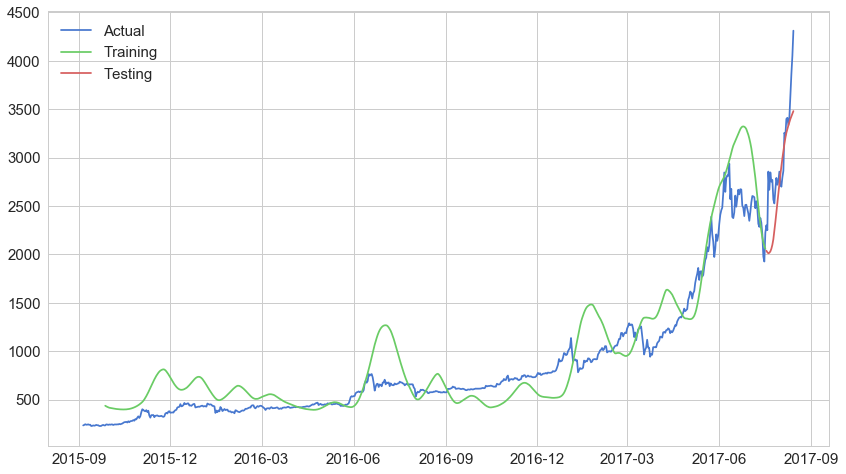

income ACTUAL: 
2868.99296326
income PREDICTED: 
1405.92800016
% TRUE predicted labels for TREND:
0.642857142857


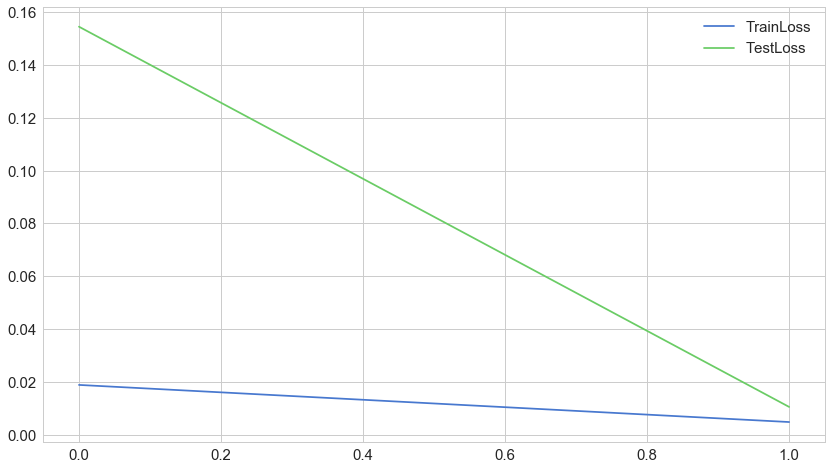

In [61]:
USD_BTC = nextDayPrediction('USDT_BTC', 'poloniex')